In [12]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.despine()

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [13]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

# Cluster specific prediction

In [14]:
ref_type = 'log2_median_ic50_hn'
model_name = 'hn_drug_cw_dw10_100000_model'
norm_type = 'TMM'

input_dir = '../result/HN_model/{}/'.format(norm_type)

In [15]:
single_drug_pred_df = pd.read_csv(input_dir + 'pred_drug_kill_{}_{}.csv'.format(ref_type, model_name))
single_drug_pred_df = single_drug_pred_df[single_drug_pred_df['patient']!='HN182']
single_drug_pred_df.head()

patient  drug_id      cluster  \
0   HN120     1001  D1|D2|G1|G2   
1   HN120     1003  D1|D2|G1|G2   
2   HN120     1004  D1|D2|G1|G2   
3   HN120     1006  D1|D2|G1|G2   
4   HN120     1007  D1|D2|G1|G2   

                                           cluster_p  \
0  0.31318681318681|0.17582417582418|0.3406593406...   
1  0.31318681318681|0.17582417582418|0.3406593406...   
2  0.31318681318681|0.17582417582418|0.3406593406...   
3  0.31318681318681|0.17582417582418|0.3406593406...   
4  0.31318681318681|0.17582417582418|0.3406593406...   

                                       cluster_delta  delta  \
0  0.53898051042886|0.88374605481702|-0.215334354...   0.35   
1  0.30341002340334|1.254172965439|-1.61865930580...  -0.23   
2  1.0946377740867|1.7738044575596|0.159122370072...   0.92   
3  0.3182886783094|0.91352077687201|0.34798103448...   0.55   
4  1.8732699997103|1.5329870813724|2.649746108863...   2.34   

                                        cluster_kill   kill  \
0  40.767315541484|35.147406141554|53.72454793660...  41.62   
1  44.761598326589|29.539447204588|75.43537879021...  50.91   
2  31.891878342425|22.626762611057|47.24541135201...  32.85   
3  44.506740829483|34.67843164505|43.999014004988...  38.31   
4  21.442568863204|25.681563932598|13.7446308051|...  16.33   

             drug_name  
0  AICA Ribonucleotide  
1         Camptothecin  
2          Vinblastine  
3           Cytarabine  
4            Docetaxel

In [16]:
single_drug_id_list = [1007, 133, 201, 1010] + [182, 301, 302] + [1012]

In [17]:
kill_df = single_drug_pred_df[single_drug_pred_df['drug_id'].isin(single_drug_id_list)].pivot(index='patient', columns='drug_name', values='kill')
kill_df

drug_name  Docetaxel  Doxorubicin  Epothilone B  Gefitinib  \
patient                                                      
HN120          16.33        49.05         19.81      23.14   
HN137          23.66        53.08         44.33      25.99   
HN148          13.53        39.20          7.83      25.14   
HN159          21.01        64.49         48.77      19.96   
HN160          10.59        51.88         44.48      12.59   

drug_name  Obatoclax Mesylate  PHA-793887  PI-103  Vorinostat  
patient                                                        
HN120                   30.48       46.62   50.78       51.57  
HN137                   44.53       44.80   40.51       42.91  
HN148                   12.09       34.49   24.91       39.82  
HN159                   55.73       59.63   61.44       57.16  
HN160                   40.52       85.66   97.48       32.37

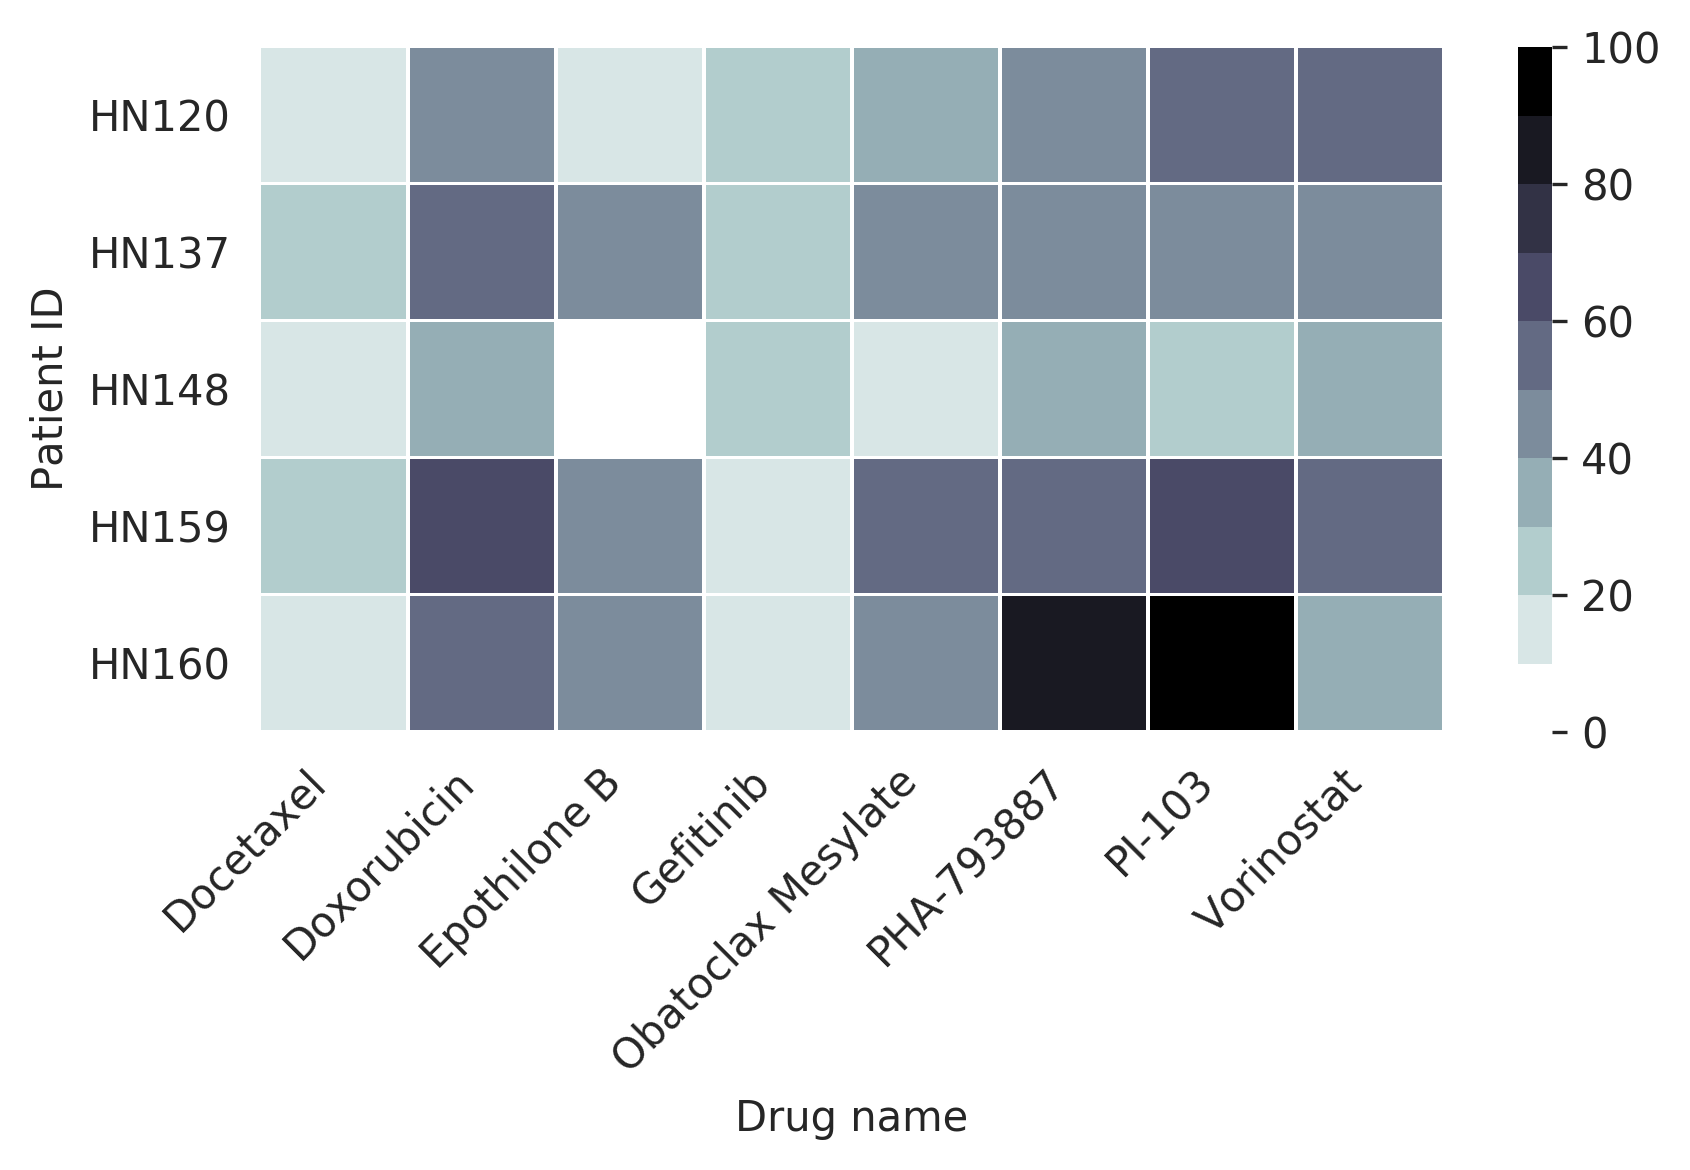

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))
cmap = plt.cm.get_cmap('bone_r', 10)
sns.heatmap(kill_df, cmap=cmap, vmin=0, vmax=100, linewidth=0.5, ax=ax)

_ = plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, horizontalalignment='right')
_ = plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, horizontalalignment='right')

ax.set_xlabel('Drug name')
ax.set_ylabel('Patient ID')

plt.tight_layout()
plt.savefig('../figure/supplementary_pred_patient.svg')

# GDSC vs CCLE

In [19]:
gdsc_df = pd.read_csv('../data/GDSC/GDSC1_dose_response.csv')
gdsc_df.head()

SCAN_ID  COSMIC_ID cell line name  DRUG_ID  drug name  Dosage (uM)  \
0     1765     924238             K5     1007  Docetaxel     1.25e-02   
1     1765     924238             K5     1007  Docetaxel     6.25e-03   
2     1765     924238             K5     1007  Docetaxel     3.13e-03   
3     1765     924238             K5     1007  Docetaxel     1.56e-03   
4     1765     924238             K5     1007  Docetaxel     7.81e-04   

   Response  
0    -81.63  
1    -89.53  
2    -71.73  
3    -67.48  
4    -47.36

In [20]:
ccle_df = pd.read_csv('../data/GDSC/CCLE_dose_response.csv')
ccle_df.head()

cell line name                 CCLE_CELL_LINE drug name CCEL_DRUG  \
0         1321N1  1321N1_CENTRAL_NERVOUS_SYSTEM    AEW541    AEW541   
1         1321N1  1321N1_CENTRAL_NERVOUS_SYSTEM    AEW541    AEW541   
2         1321N1  1321N1_CENTRAL_NERVOUS_SYSTEM    AEW541    AEW541   
3         1321N1  1321N1_CENTRAL_NERVOUS_SYSTEM    AEW541    AEW541   
4         1321N1  1321N1_CENTRAL_NERVOUS_SYSTEM    AEW541    AEW541   

   Dosage (uM)  Response  
0     2.50e-03      8.67  
1     8.00e-03     11.00  
2     2.50e-02      2.16  
3     8.00e-02      0.27  
4     2.50e-01    -10.00

In [21]:
[cl for cl in ccle_df['CCLE_CELL_LINE'] if 'HEAD' in cl]

[]

In [22]:
cl_df = pd.read_excel('../data/GDSC/metadata_2019_09_20.xlsx', sheet_name='cell line')
cl_df.head()

name   GDSC id GDSC name                               CCLE name  \
0     697  9.07e+05       697  697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE   
1    5637  6.87e+05      5637                      5637_URINARY_TRACT   
2  1321N1       NaN       NaN           1321N1_CENTRAL_NERVOUS_SYSTEM   
3    143B       NaN       NaN                               143B_BONE   
4    201T  1.29e+06      201T                                     NaN   

   CTRP id CTRP name  NCI60 id  NCI60 name  \
0      NaN       NaN       NaN         NaN   
1    643.0      5637       NaN         NaN   
2      NaN       NaN       NaN         NaN   
3      NaN       NaN       NaN         NaN   
4      NaN       NaN       NaN         NaN   

                          CCLE tissue        GDSC tissue  \
0  HAEMATOPOIETIC_AND_LYMPHOID_TISSUE              blood   
1                       URINARY_TRACT  urogenital_system   
2              CENTRAL_NERVOUS_SYSTEM                NaN   
3                                BONE                NaN   
4                                 NaN               lung   

                GDSC subtype    TCGA class  
0     lymphoblastic_leukemia  UNCLASSIFIED  
1                    bladder          BLCA  
2                        NaN           NaN  
3                        NaN           NaN  
4  lung_NSCLC_adenocarcinoma          LUAD

In [23]:
common_cl_df = cl_df[(~cl_df['CCLE name'].isnull()) & (~cl_df['GDSC id'].isnull()) & (cl_df['GDSC subtype'] == 'head_and_neck')]
common_cl_df.shape

(16, 12)

In [24]:
drug_df = pd.read_excel('../data/GDSC/metadata_2019_09_20.xlsx', sheet_name='drug')
drug_df.head()

DRUG NAME ANTICANCER LIBRARY NAME CCLE DRUG NAME GDSC DRUG NAME  \
0  Tanespimycin                     NaN         17-AAG   Tanespimycin   
1        AEW541                     NaN         AEW541            NaN   
2   Saracatinib   Saracatinib (AZD0530)        AZD0530    Saracatinib   
3   Selumetinib                     NaN        AZD6244    Selumetinib   
4     Erlotinib           Erlotinib HCl      Erlotinib      Erlotinib   

  GDSC DRUG ID P400 DRUG NAME  CMAX (uM)  \
0         1026            NaN        NaN   
1          NaN            NaN        NaN   
2           38            NaN        NaN   
3    1062;1498            NaN        NaN   
4       1;1168      Erlotinib       3.15   

                                            SYNONYMS PUTATIVE TARGET  \
0                                 17-AAG, BMS-722782           HSP90   
1                                                NaN          IGF-1R   
2                     AZD0530, AZD-0530, AZ-10353926        ABL, SRC   
3                        AZD6244, AZD-6244, ARRY-886      MEK1, MEK2   
4  Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...            EGFR   

                        PATHWAY NAME  
0  Protein stability and degradation  
1                                NaN  
2                     Other, kinases  
3                 ERK MAPK signaling  
4                     EGFR signaling

In [25]:
common_drug_df = drug_df[(~drug_df['CCLE DRUG NAME'].isnull()) & (~drug_df['GDSC DRUG NAME'].isnull())]
common_drug_df.shape

(18, 10)

In [26]:
selected_drugs = []

for _, drug_row in common_drug_df.iterrows():
    d_gdsc_df = gdsc_df[(gdsc_df['DRUG_ID']==int(drug_row['GDSC DRUG ID'].split(';')[0])) & (gdsc_df['COSMIC_ID'].isin(common_cl_df['GDSC id']))]
    d_ccle_df = ccle_df[(ccle_df['drug name']==drug_row['CCLE DRUG NAME']) & (ccle_df['CCLE_CELL_LINE'].isin(common_cl_df['CCLE name']))]
    
#     print (drug_row['DRUG NAME'], d_gdsc_df.shape, d_ccle_df.shape)
    if d_gdsc_df.shape[0] > 0 and d_ccle_df.shape[0] > 0:
        selected_drugs += [drug_row['DRUG NAME']]
        
selected_drugs

['Erlotinib',
 'Lapatinib',
 'Nilotinib',
 'Paclitaxel',
 'Panobinostat',
 'PHA-665752',
 'Sorafenib']

In [27]:
selected_drug = 'Nilotinib'

Erlotinib 1 (27, 7) (48, 6)
Lapatinib 1 (27, 7) (56, 6)
Nilotinib 4 (171, 7) (32, 6)
Paclitaxel 1 (18, 7) (56, 6)
Panobinostat 6 (153, 7) (48, 6)
PHA-665752 1 (18, 7) (56, 6)
Sorafenib 1 (18, 7) (56, 6)


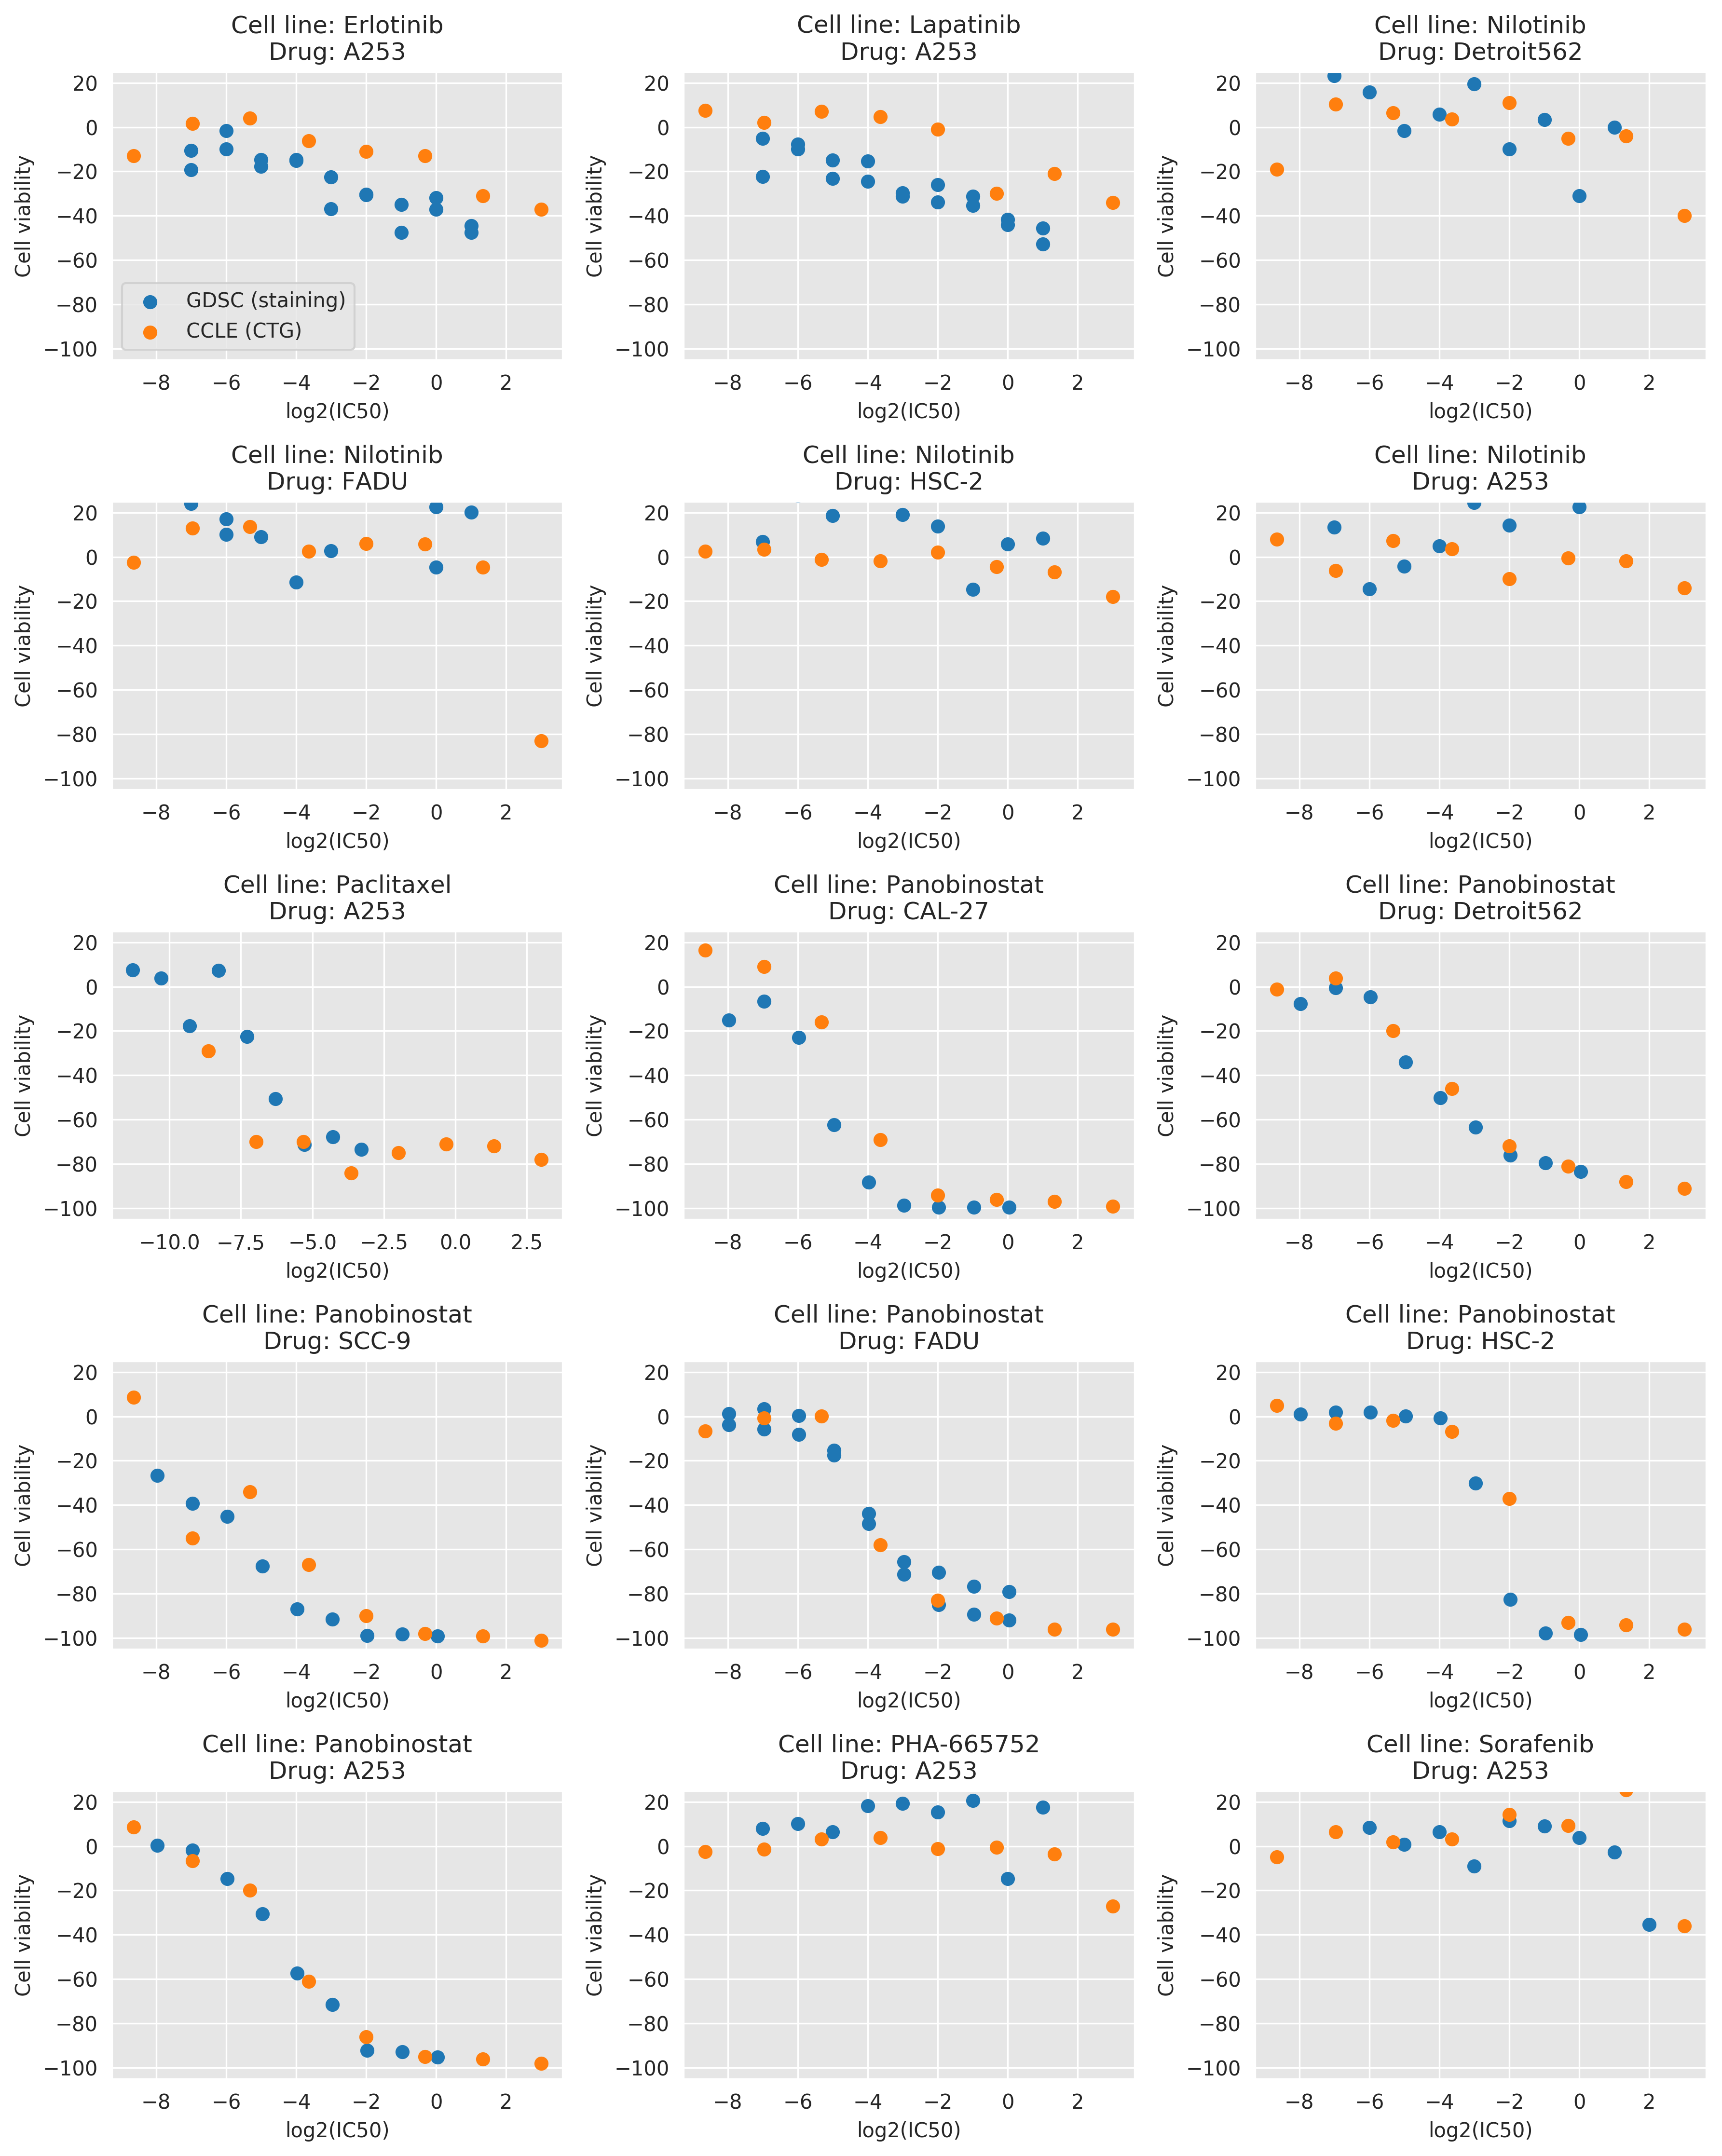

In [28]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))
axes = axes.flatten()
count = 0

for _, drug_row in common_drug_df[common_drug_df['DRUG NAME'].isin(selected_drugs)].iterrows():
    d_gdsc_df = gdsc_df[(gdsc_df['DRUG_ID']==int(drug_row['GDSC DRUG ID'].split(';')[0])) & (gdsc_df['COSMIC_ID'].isin(common_cl_df['GDSC id']))]
    d_ccle_df = ccle_df[(ccle_df['drug name']==drug_row['CCLE DRUG NAME']) & (ccle_df['CCLE_CELL_LINE'].isin(common_cl_df['CCLE name']))]
    
    common_lines = set(d_ccle_df['cell line name']).intersection(d_gdsc_df['cell line name'])

    print (drug_row['DRUG NAME'], len(common_lines), d_gdsc_df.shape, d_ccle_df.shape)

    
    for cl in common_lines:
        
        ax = axes[count]
        count += 1
        
        gdsc_x = d_gdsc_df[d_gdsc_df['cell line name']==cl]['Dosage (uM)'].values
        gdsc_y = d_gdsc_df[d_gdsc_df['cell line name']==cl]['Response'].values

        ccle_x = d_ccle_df[d_ccle_df['cell line name']==cl]['Dosage (uM)'].values
        ccle_y = d_ccle_df[d_ccle_df['cell line name']==cl]['Response'].values     
        
        ax.scatter(np.log2(gdsc_x), gdsc_y, label='GDSC (staining)')
        ax.scatter(np.log2(ccle_x), ccle_y, label='CCLE (CTG)')

        ax.set_ylabel('Cell viability')
        ax.set_xlabel('log2(IC50)')
        ax.set_title('Cell line: {}\nDrug: {}'.format(drug_row['DRUG NAME'], cl))
        
        ax.set_ylim((-105, 25))
        
        if count == 1:
            ax.legend(loc='lower left')

plt.tight_layout()

plt.savefig('../figure/supplementary_ccle_vs_gdsc_hn.svg')

# Prediction range

In [44]:
output_dir = '../result/HN_model/TPM/'
model_name = 'hn_drug_cw_dw10_100000'

model_training_output_dict = pickle.load(open('../result/HN_model/{}_output_dict.pickle'.format(model_name), 'rb'))

In [105]:
hn_drug_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv')
hn_drug_id_max_dosage_dict = dict(zip(hn_drug_df['Drug ID'].astype(str), hn_drug_df['log2_median_ic50_hn']))
hn_drug_id_name_dict = dict(zip(hn_drug_df['Drug ID'].astype(str), hn_drug_df['Drug Name']))

In [45]:
cluster_pred_df = pd.read_csv(os.path.join(output_dir,'pred_{}_model.csv'.format('gdsc_no_bias_{}').format(model_name)), index_col=0)
cluster_pred_df.head()

1001  1003  1004  1006  1007  1010      1012  1014  1015  1016  ...  \
A1  10.40 -4.98 -6.04  0.98 -6.94 -0.01  7.38e-01  2.65  3.53 -1.85  ...   
A2   9.96 -6.81 -7.07 -0.29 -7.48  0.02  3.01e-03  2.13  2.97 -2.29  ...   
B1  11.02 -4.75 -5.25  1.58 -6.23  1.14  1.97e+00  3.36  4.35 -1.45  ...   
B2  10.65 -5.56 -6.36  0.92 -7.03  0.89  1.62e+00  3.19  4.28 -1.90  ...   
C1  10.63 -6.01 -4.89  0.63 -6.37  0.42  9.94e-01  2.14  2.94 -1.30  ...   

     299   301   302   303   305   306   308   328   331   346  
A1  0.57  2.48  0.21  3.19  3.69  2.49 -0.70 -1.43  1.61 -3.96  
A2  0.53  2.16  0.41  2.87  3.22  2.27 -1.16 -2.39  1.40 -4.56  
B1  1.29  2.59  0.80  3.88  4.24  2.82  1.65  0.31  1.95 -1.25  
B2  0.93  2.22  0.36  3.61  3.82  2.40  1.09 -0.61  1.70 -2.00  
C1  1.86  2.96  1.63  3.75  4.23  3.03  0.04 -1.02  2.10 -2.57  

[5 rows x 81 columns]

In [46]:
model_training_output_dict['pred_train_df'].head()

Drug ID   1001  1003  1004  1006   1007  1010  1012  1014  1015  1016  ...  \
1299081  11.44 -5.21 -4.94  1.10  -6.70  1.03  2.09  1.39  2.53 -1.36  ...   
713899   11.43 -3.66 -3.95  2.23  -5.84  1.43  2.42  5.76  6.06 -0.08  ...   
906863   10.10 -8.44 -7.06 -1.23 -10.19 -1.53  1.00  0.24  1.19 -2.69  ...   
1290814  11.31 -3.97 -4.80  1.41  -5.88  1.46  0.97  2.67  3.73 -0.76  ...   
907268   10.42 -5.86 -5.47  1.29  -4.36  1.91  1.17  4.03  4.76 -1.78  ...   

Drug ID   299   301   302   303   305   306   308   328   331   346  
1299081  1.68  3.25  1.04  3.96  4.88  3.49  0.35 -0.99  1.77 -2.95  
713899  -1.08  1.59 -0.98  2.90  3.97  2.28  0.98 -0.51  0.34 -3.06  
906863   5.41  3.85  4.13  5.40  5.91  4.46  2.59  1.40  3.51  1.11  
1290814  4.87  5.19  3.99  4.92  5.02  4.08 -1.03  0.36  4.00 -2.35  
907268  -4.57 -0.49 -3.49  1.10  1.57  0.46  0.32 -3.28 -1.10 -4.99  

[5 rows x 81 columns]

In [47]:
model_training_output_dict['obs_train_df'].head()

Drug ID   1001  1003  1004  1006  1007  1010  1012  1014  1015  1016  ...  \
1299081  11.34 -7.10 -6.42 -1.04 -7.95  7.64  2.92  1.82  2.38 -3.31  ...   
713899    9.84 -7.24 -6.68  1.79 -7.54  2.90  0.25  6.52  5.41  0.22  ...   
906863    9.94 -8.75 -5.90 -1.26 -9.45 -2.08  0.45 -0.84  1.76 -2.21  ...   
1290814    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
907268   10.64 -5.97 -6.41  3.75 -6.32  5.22  1.02  6.41  3.32 -3.30  ...   

Drug ID   299    301   302   303   305   306   308   328    331   346  
1299081 -0.20   2.06 -1.22  3.42  9.05  2.37 -0.35 -4.27  10.22  1.32  
713899  -0.86   0.11 -3.56  2.39  2.35  0.25 -2.29 -2.72  -0.82 -3.66  
906863   7.52   3.64  5.44  6.24  5.99  3.61  1.83  2.39   3.16  0.72  
1290814  8.24  10.57  9.50  9.38  6.31  3.64  5.03  3.97   6.77  0.51  
907268   1.87   1.69  1.91  2.08  1.92  3.10  0.55 -3.00   2.53 -3.90  

[5 rows x 81 columns]

In [100]:
drug_id = '201' # 1007 | 1010

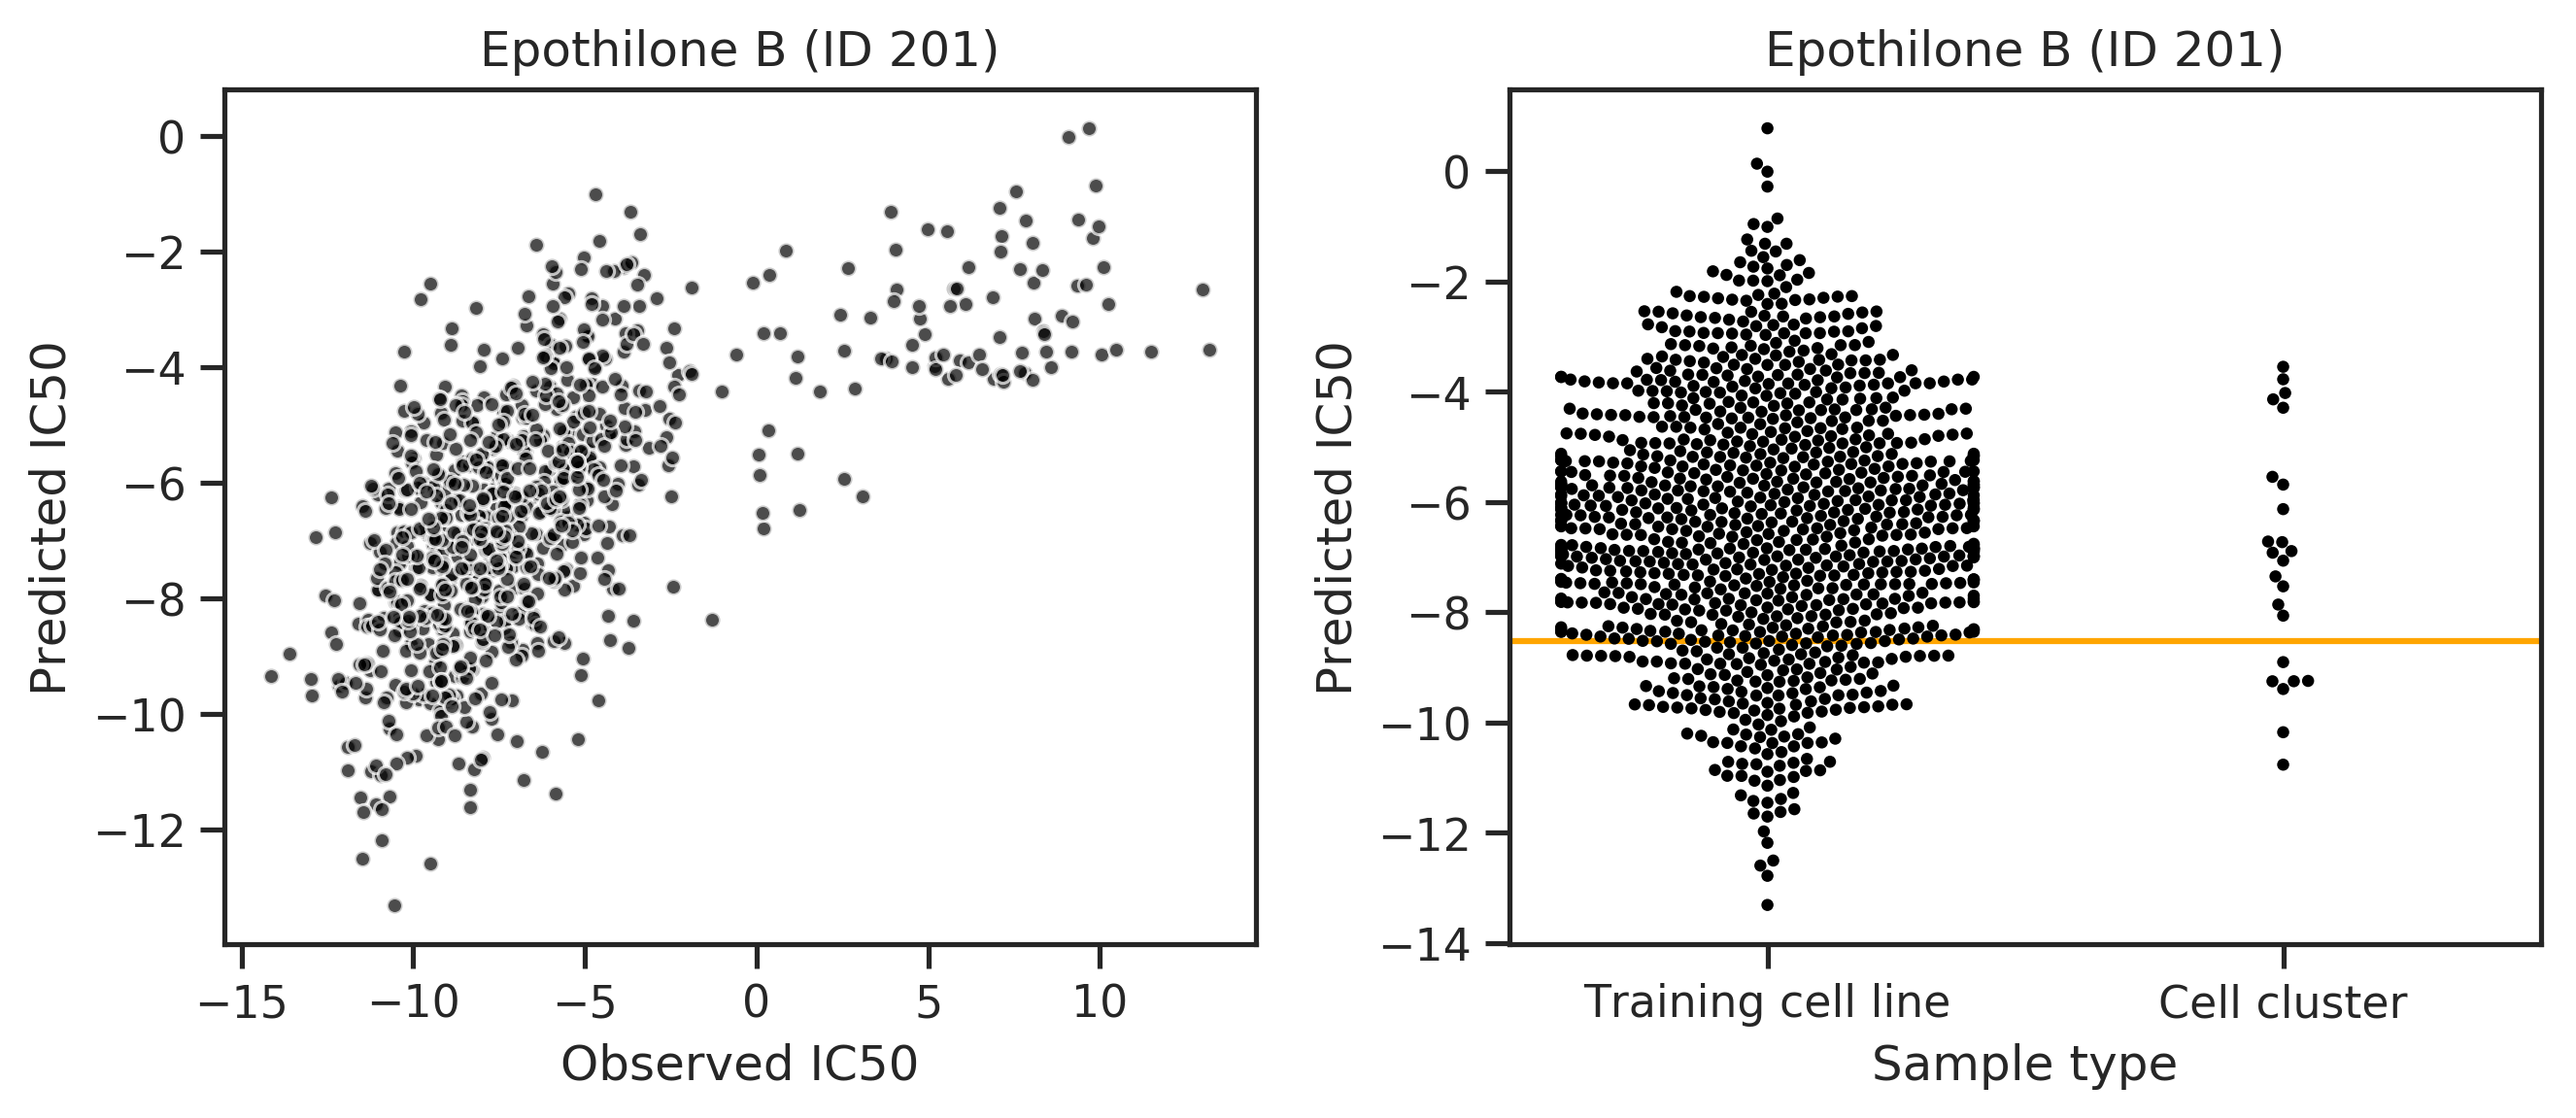

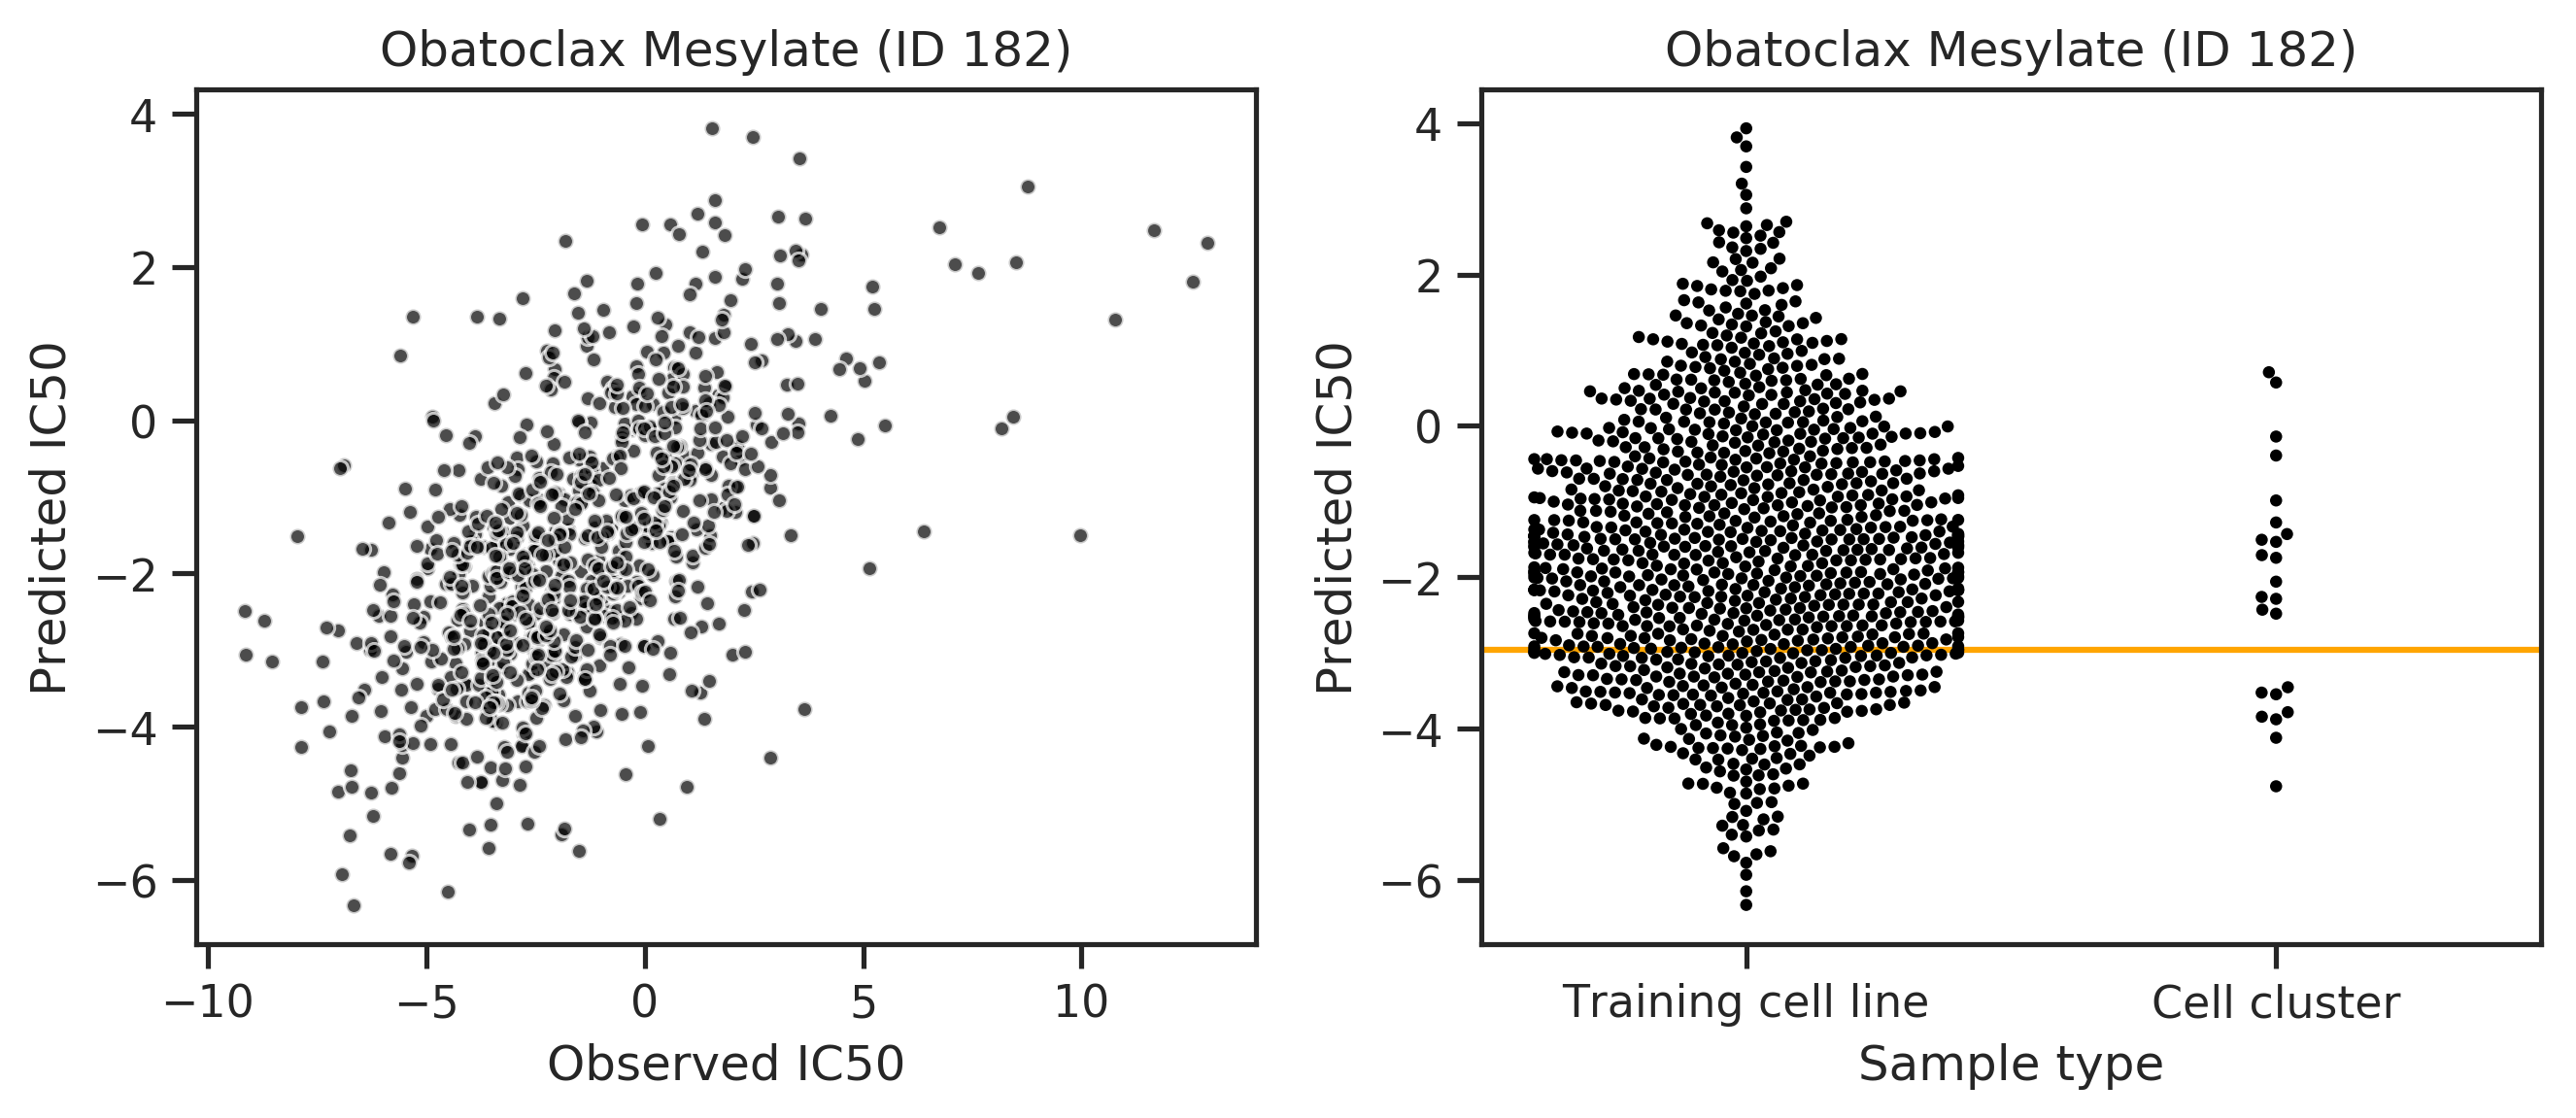

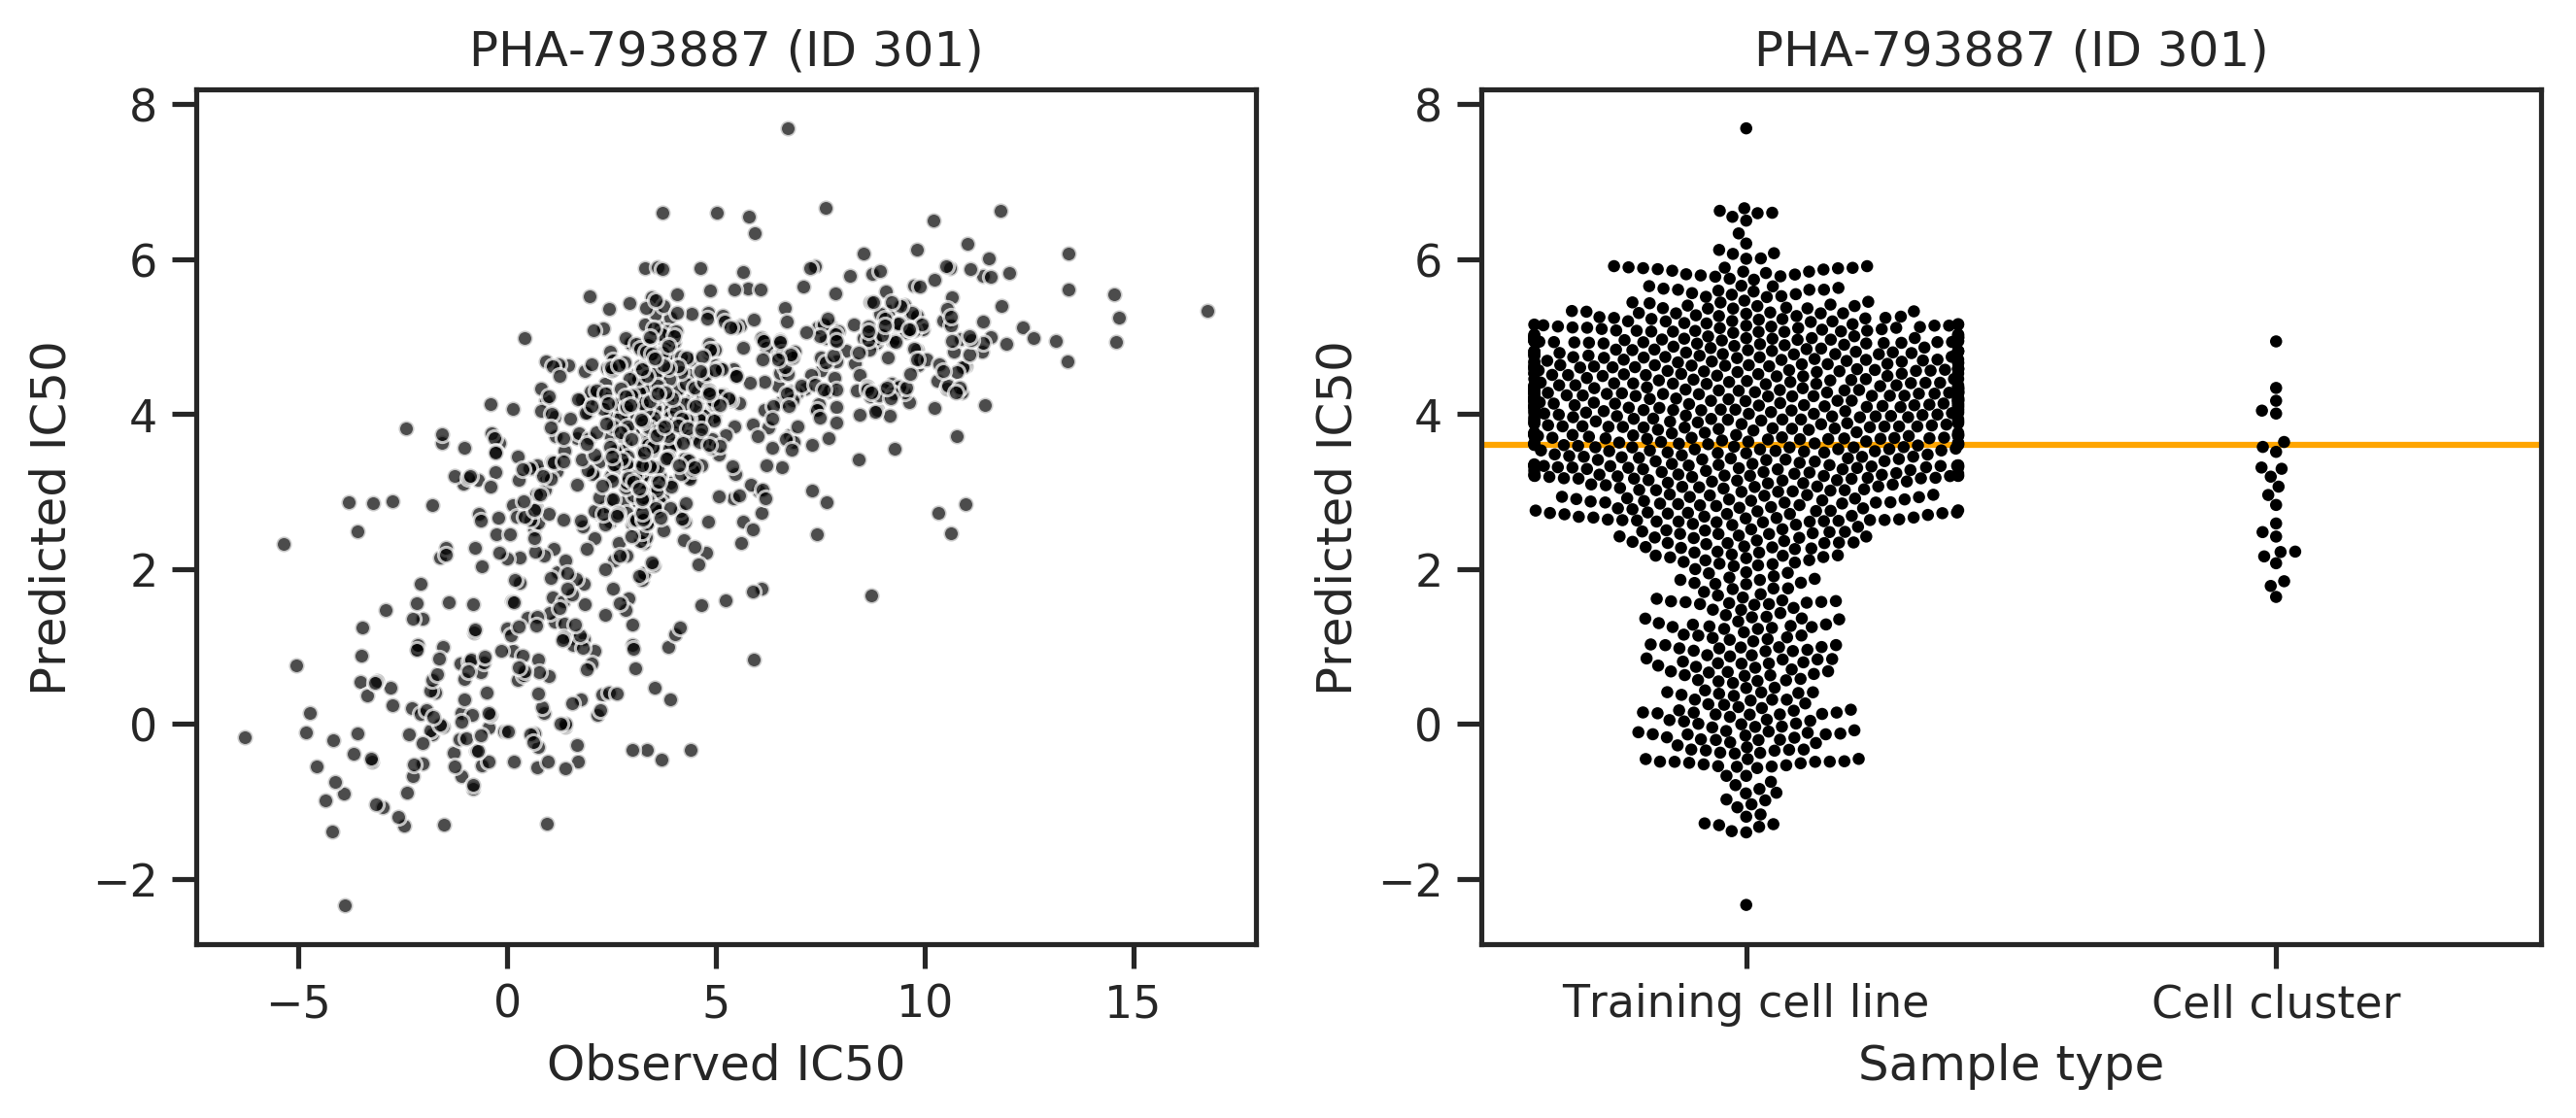

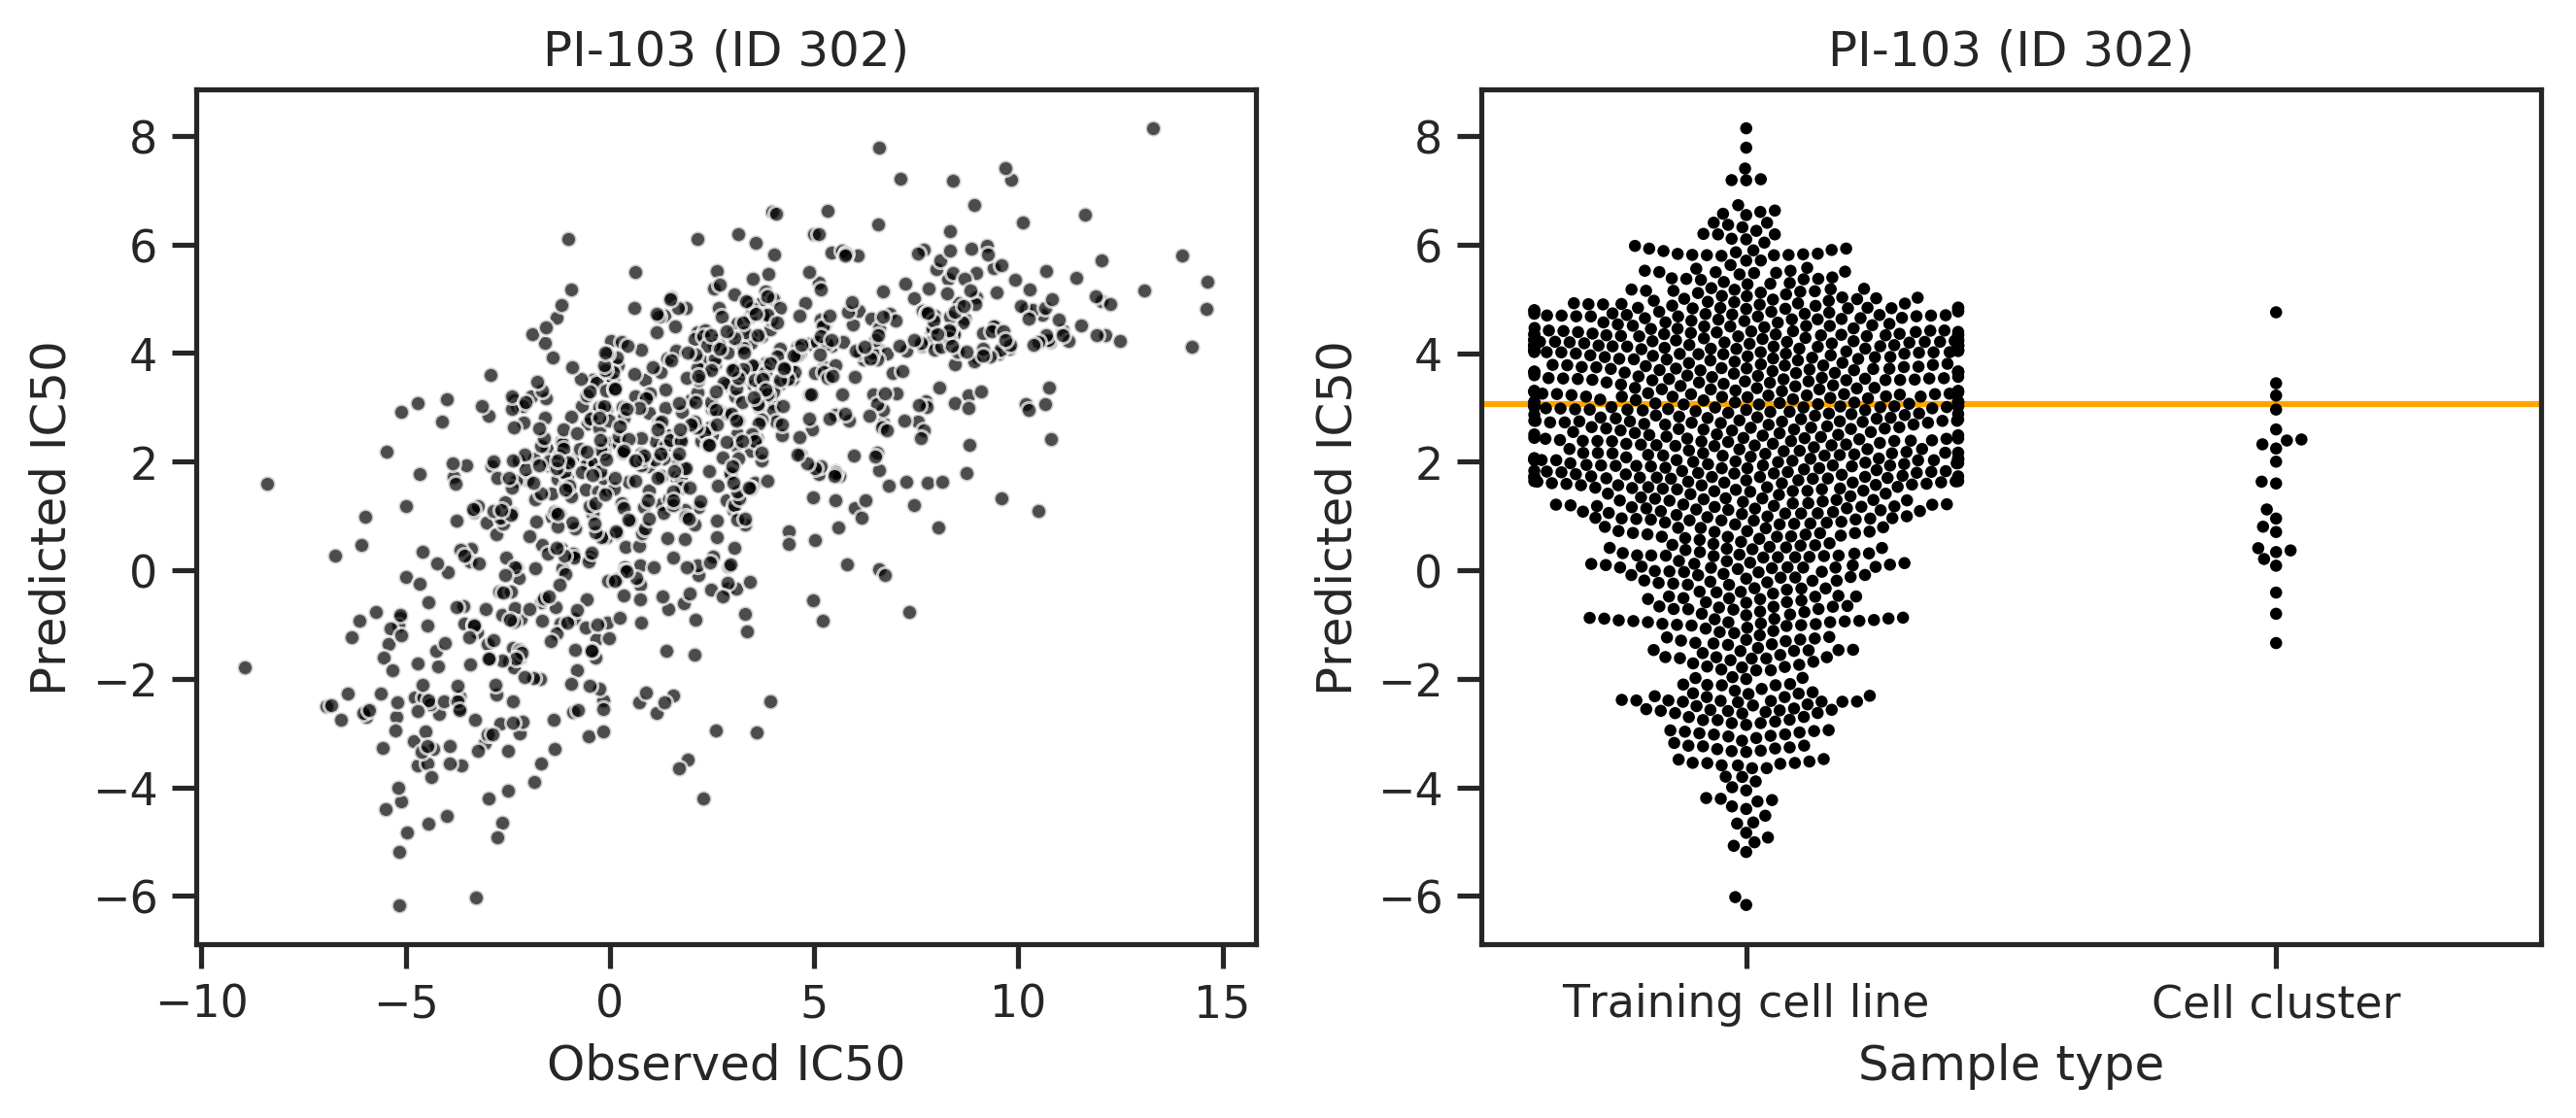

In [112]:
for drug_id in [str(d) for d in single_drug_id_list]:

    sns.set(style='ticks', font_scale=1.0)
    fig, axes = plt.subplots(ncols=2, figsize=(9, 4))

    ax = axes[0]

    x = model_training_output_dict['obs_train_df'][drug_id]
    y_train = model_training_output_dict['pred_train_df'][drug_id]
    y_test = cluster_pred_df[drug_id]

    sns.scatterplot(x, y_train, s=15, alpha=0.7, color='black', ax=ax)
    ax.set_xlabel('Observed IC50')
    ax.set_ylabel('Predicted IC50')
    ax.set_title("{} (ID {})".format(hn_drug_id_name_dict[drug_id], drug_id))

    ax = axes[1]

    y_test_df = pd.DataFrame(y_test)
    y_test_df.loc[:, 'Sample type'] = 'Cell cluster'

    y_train_df = pd.DataFrame(y_train)
    y_train_df.loc[:, 'Sample type'] = 'Training cell line'

    y_df = pd.concat([y_train_df, y_test_df], axis=0)

    sns.swarmplot(data=y_df, y=drug_id, x='Sample type', s=3, color='black', ax=ax)
    ax.axhline(y=hn_drug_id_max_dosage_dict[drug_id], color='orange')
    ax.set_ylabel('Predicted IC50')
    ax.set_title("{} (ID {})".format(hn_drug_id_name_dict[drug_id], drug_id))

    plt.tight_layout()
    plt.savefig('../figure/supplementary_pred_range_{}.svg'.format(hn_drug_id_name_dict[drug_id]))

# GDSC 1 vs 2 [NOT IN USE]

https://www.cancerrxgene.org/help#t_curve

These are not included as both GDSC datasets use differrent negative controls.

In [2]:
gdsc1_df = pd.read_excel('../data/GDSC/GDSC1_fitted_dose_response_17Jul19.xlsx')
gdsc1_df.head()

DATASET  NLME_RESULT_ID  NLME_CURVE_ID  COSMIC_ID CELL_LINE_NAME  \
0   GDSC1             261       12258263     683665         MC-CAR   
1   GDSC1             261       12259075     684055            ES3   
2   GDSC1             261       12259376     684057            ES5   
3   GDSC1             261       12259663     684059            ES7   
4   GDSC1             261       12259967     684062          EW-11   

  SANGER_MODEL_ID     TCGA_DESC  DRUG_ID  DRUG_NAME PUTATIVE_TARGET  \
0       SIDM00636            MM        1  Erlotinib            EGFR   
1       SIDM00265  UNCLASSIFIED        1  Erlotinib            EGFR   
2       SIDM00263  UNCLASSIFIED        1  Erlotinib            EGFR   
3       SIDM00269  UNCLASSIFIED        1  Erlotinib            EGFR   
4       SIDM00203  UNCLASSIFIED        1  Erlotinib            EGFR   

     PATHWAY_NAME  COMPANY_ID WEBRELEASE  MIN_CONC  MAX_CONC  LN_IC50   AUC  \
0  EGFR signaling        1045          Y  7.81e-03       2.0     2.40  0.98   
1  EGFR signaling        1045          Y  7.81e-03       2.0     3.14  0.98   
2  EGFR signaling        1045          Y  7.81e-03       2.0     3.97  0.99   
3  EGFR signaling        1045          Y  7.81e-03       2.0     2.69  0.97   
4  EGFR signaling        1045          Y  7.81e-03       2.0     2.48  0.94   

   RMSE  Z_SCORE  
0  0.02    -0.19  
1  0.03     0.51  
2  0.03     1.28  
3  0.11     0.09  
4  0.09    -0.11

In [3]:
gdsc1_mat_df = gdsc1_df[gdsc1_df['LN_IC50'] <= gdsc1_df['MAX_CONC']].pivot(index='COSMIC_ID', columns='DRUG_ID', values='LN_IC50')
gdsc1_mat_df.head()

DRUG_ID    1     3     5     6     9     11    17    29    30    32    ...  \
COSMIC_ID                                                              ...   
683665      NaN -0.66  2.16   NaN  0.53 -3.65  4.30  2.06  3.44   0.7  ...   
683667      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
684052      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
684055      NaN -0.07  3.04   NaN   NaN -0.36  4.89  2.07  2.05   NaN  ...   
684057      NaN   NaN  3.77   NaN  0.93   NaN  5.70  2.67  3.44   NaN  ...   

DRUG_ID    1377  1378  1494  1495  1498  1502  1526  1527  1529  1530  
COSMIC_ID                                                              
683665     3.67  4.05 -4.43  4.14  2.98  4.03  2.01  1.02   NaN   NaN  
683667     4.11  1.11 -4.14   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
684052     3.82  1.70 -6.84  1.35  1.71  4.22  1.96 -0.44 -2.04  4.27  
684055     2.30  0.58 -6.85  1.61  3.23  4.20  3.12  0.81 -0.56  4.66  
684057     4.15  1.76 -6.22  2.35  3.40  4.51  4.23 -0.72 -0.54  4.79  

[5 rows x 320 columns]

In [4]:
gdsc1_mc_df = gdsc1_df.pivot(index='COSMIC_ID', columns='DRUG_ID', values='MAX_CONC')

In [5]:
gdsc2_df = pd.read_excel('../data/GDSC/GDSC2_fitted_dose_response_17Jul19.xlsx')
gdsc2_df.head()

DATASET  NLME_RESULT_ID  NLME_CURVE_ID  COSMIC_ID CELL_LINE_NAME  \
0   GDSC2             262       12605935     909751           SW48   
1   GDSC2             262       12605949     905962          SW620   
2   GDSC2             262       12605963     910927         CAL-51   
3   GDSC2             262       12605996     908442       NCI-H508   
4   GDSC2             262       12606017     909740        SNU-C2B   

  SANGER_MODEL_ID TCGA_DESC  DRUG_ID     DRUG_NAME PUTATIVE_TARGET  \
0       SIDM00837    COREAD     1003  Camptothecin            TOP1   
1       SIDM00841    COREAD     1003  Camptothecin            TOP1   
2       SIDM00933      BRCA     1003  Camptothecin            TOP1   
3       SIDM00777    COREAD     1003  Camptothecin            TOP1   
4       SIDM00781    COREAD     1003  Camptothecin            TOP1   

      PATHWAY_NAME  COMPANY_ID WEBRELEASE  MIN_CONC  MAX_CONC  LN_IC50   AUC  \
0  DNA replication        1046          Y  9.80e-05       0.1    -3.68  0.71   
1  DNA replication        1046          Y  9.80e-05       0.1    -3.00  0.78   
2  DNA replication        1046          Y  9.80e-05       0.1    -3.56  0.77   
3  DNA replication        1046          Y  9.80e-05       0.1    -3.22  0.73   
4  DNA replication        1046          Y  9.80e-05       0.1     0.69  0.92   

   RMSE  Z_SCORE  
0  0.13    -0.77  
1  0.10    -0.47  
2  0.09    -0.71  
3  0.10    -0.56  
4  0.08     1.15

In [20]:
drug_id_name_dict = dict(zip(gdsc2_df['DRUG_ID'].astype(str), gdsc2_df['DRUG_NAME']))
# drug_id_name_dict

In [6]:
gdsc2_mat_df = gdsc2_df[gdsc2_df['LN_IC50'] <= gdsc2_df['MAX_CONC']].pivot(index='COSMIC_ID', columns='DRUG_ID', values='LN_IC50')
gdsc2_mat_df.head()

DRUG_ID    1003  1004  1005  1006  1007  1010  1011  1012  1013  1017  ...  \
COSMIC_ID                                                              ...   
683665    -1.74 -5.87  2.69 -1.88 -5.32   NaN -1.73  0.65  2.73  2.71  ...   
683667    -2.01 -5.01  3.03   NaN -5.57  1.98  2.38  0.34  2.03  4.27  ...   
684052    -4.96 -6.04 -0.08 -1.46 -6.29   NaN  1.18  1.22  3.78  1.84  ...   
684057    -2.51   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
684059    -5.24 -5.77  0.31  0.06 -6.54   NaN  0.99  1.10  1.26  1.60  ...   

DRUG_ID    2096  2106  2107  2109  2110  2111  2169  2170  2171  2172  
COSMIC_ID                                                              
683665     2.95  2.75  4.67  1.62  2.17  2.15   NaN  3.71   NaN   NaN  
683667     2.73  1.97  4.78  1.64  5.04  4.74   NaN  3.77   NaN   NaN  
684052     2.61  3.06  4.69  1.15  2.42  2.48   NaN  2.95   NaN   NaN  
684057      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
684059     3.19  2.70  5.01  1.73  3.57  3.49   NaN  3.36   NaN   NaN  

[5 rows x 175 columns]

In [7]:
gdsc2_mc_df = gdsc2_df.pivot(index='COSMIC_ID', columns='DRUG_ID', values='MAX_CONC')

In [8]:
common_drugs = list(set(gdsc1_mat_df.columns).intersection(gdsc2_mat_df.columns))
common_samples = list(set(gdsc1_mat_df.index).intersection(gdsc2_mat_df.index))
len(common_drugs), len(common_samples)

(42, 809)

Selected drugs and cell lines

In [21]:
gdsc_tissue_df = pd.read_csv('../data/GDSC/GDSC_tissue_info.csv')

hnsc_ids = gdsc_tissue_df[gdsc_tissue_df['TCGA_CLASS']=='HNSC']['CELL_LINE'].values
hnsc_ids = [cl for cl in hnsc_ids if cl in common_samples]

In [52]:
selected_drugs = [1819, 1010, 1068, 1012]
print ([d for d in selected_drugs if d in common_drugs])
selected_drugs = [1010, 1012]
print ([drug_id_name_dict[str(d)] for d in selected_drugs])

[1010, 1012]
['Gefitinib', 'Vorinostat']


In [60]:
x1_df = gdsc1_mat_df.loc[hnsc_ids, common_drugs]
x2_df = gdsc2_mat_df.loc[hnsc_ids, common_drugs]

mc1_df = gdsc1_mc_df.loc[hnsc_ids, common_drugs]
mc2_df = gdsc2_mc_df.loc[hnsc_ids, common_drugs]

# x1_df = gdsc1_mat_df.loc[hnsc_ids, selected_drugs]
# x2_df = gdsc2_mat_df.loc[hnsc_ids, selected_drugs]

# mc1_df = gdsc1_mc_df.loc[hnsc_ids, selected_drugs]
# mc2_df = gdsc2_mc_df.loc[hnsc_ids, selected_drugs]

In [61]:
x1 = x1_df.values.flatten()
x2 = x2_df.values.flatten()
sel = np.logical_and(~np.isnan(x1), ~np.isnan(x2))

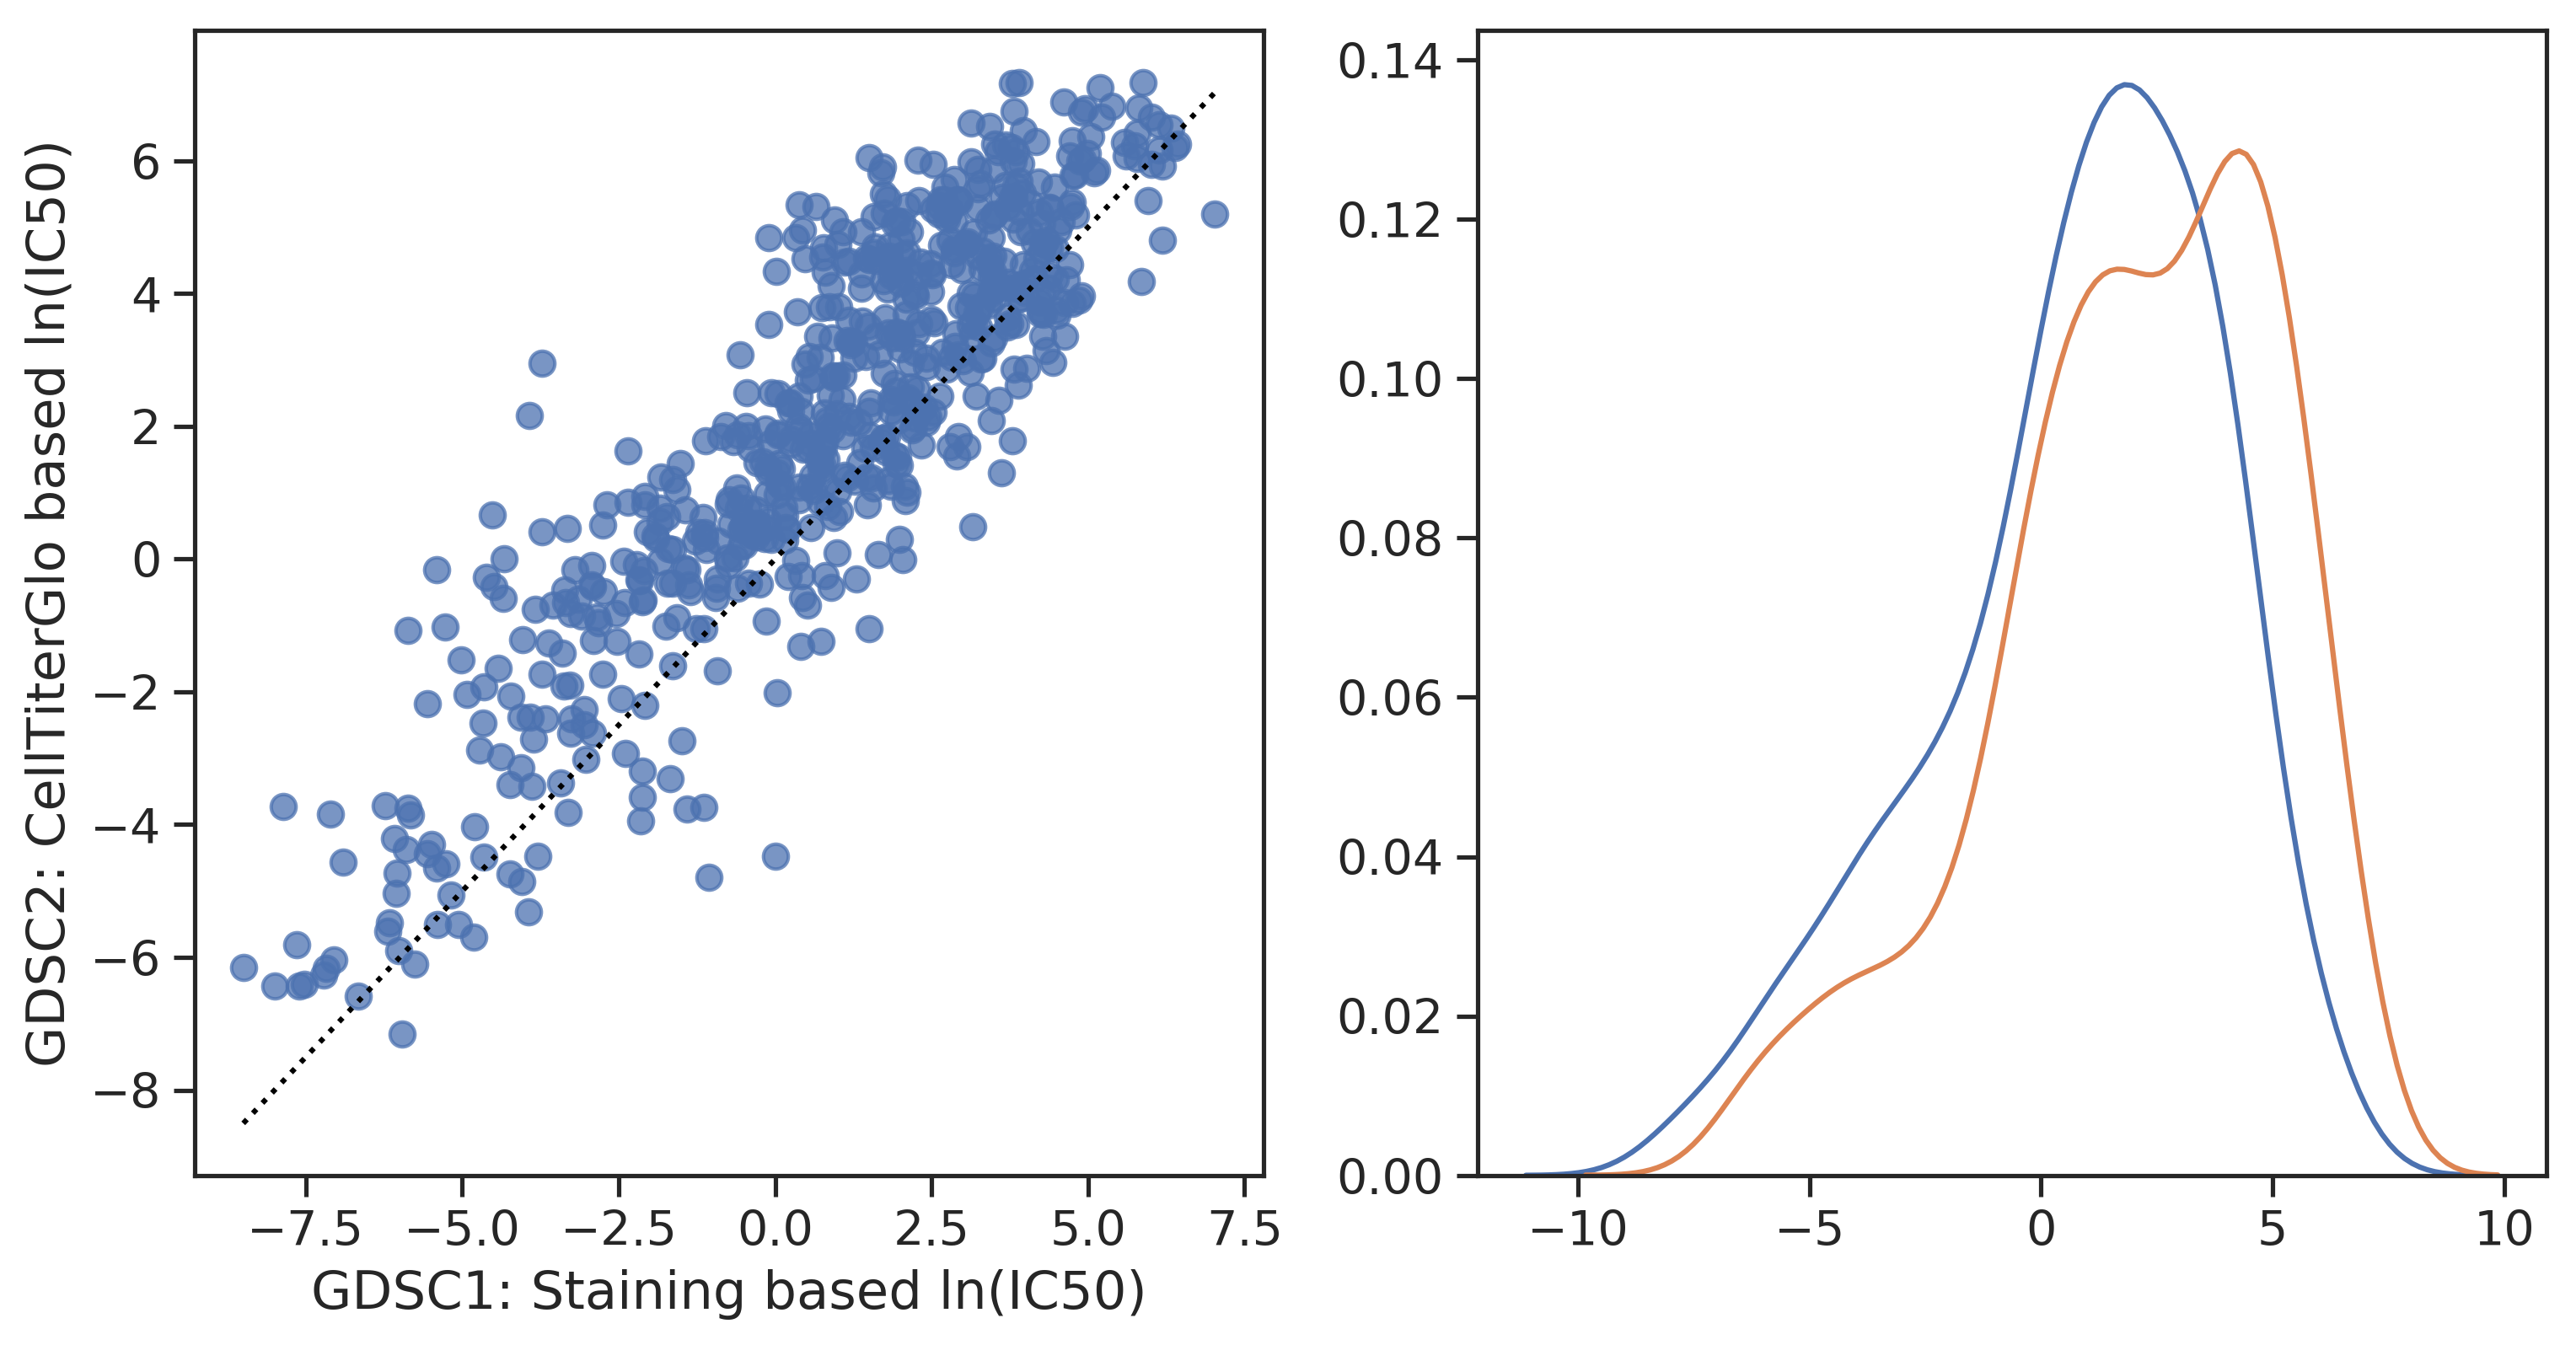

In [62]:
sns.set(font_scale=1.25, style='ticks')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

axes[0].scatter(x1[sel], x2[sel], s=50, alpha=0.75)
vmin = np.min([np.nanmin(x1), np.nanmin(x2)])
vmax = np.min([np.nanmax(x1), np.nanmax(x2)])
axes[0].plot((vmin, vmax), (vmin, vmax), color='black', linestyle=':')

axes[0].set_xlabel('GDSC1: Staining based ln(IC50)')
axes[0].set_ylabel('GDSC2: CellTiterGlo based ln(IC50)')

sns.kdeplot(x1[sel], ax=axes[1])
sns.kdeplot(x2[sel], ax=axes[1])

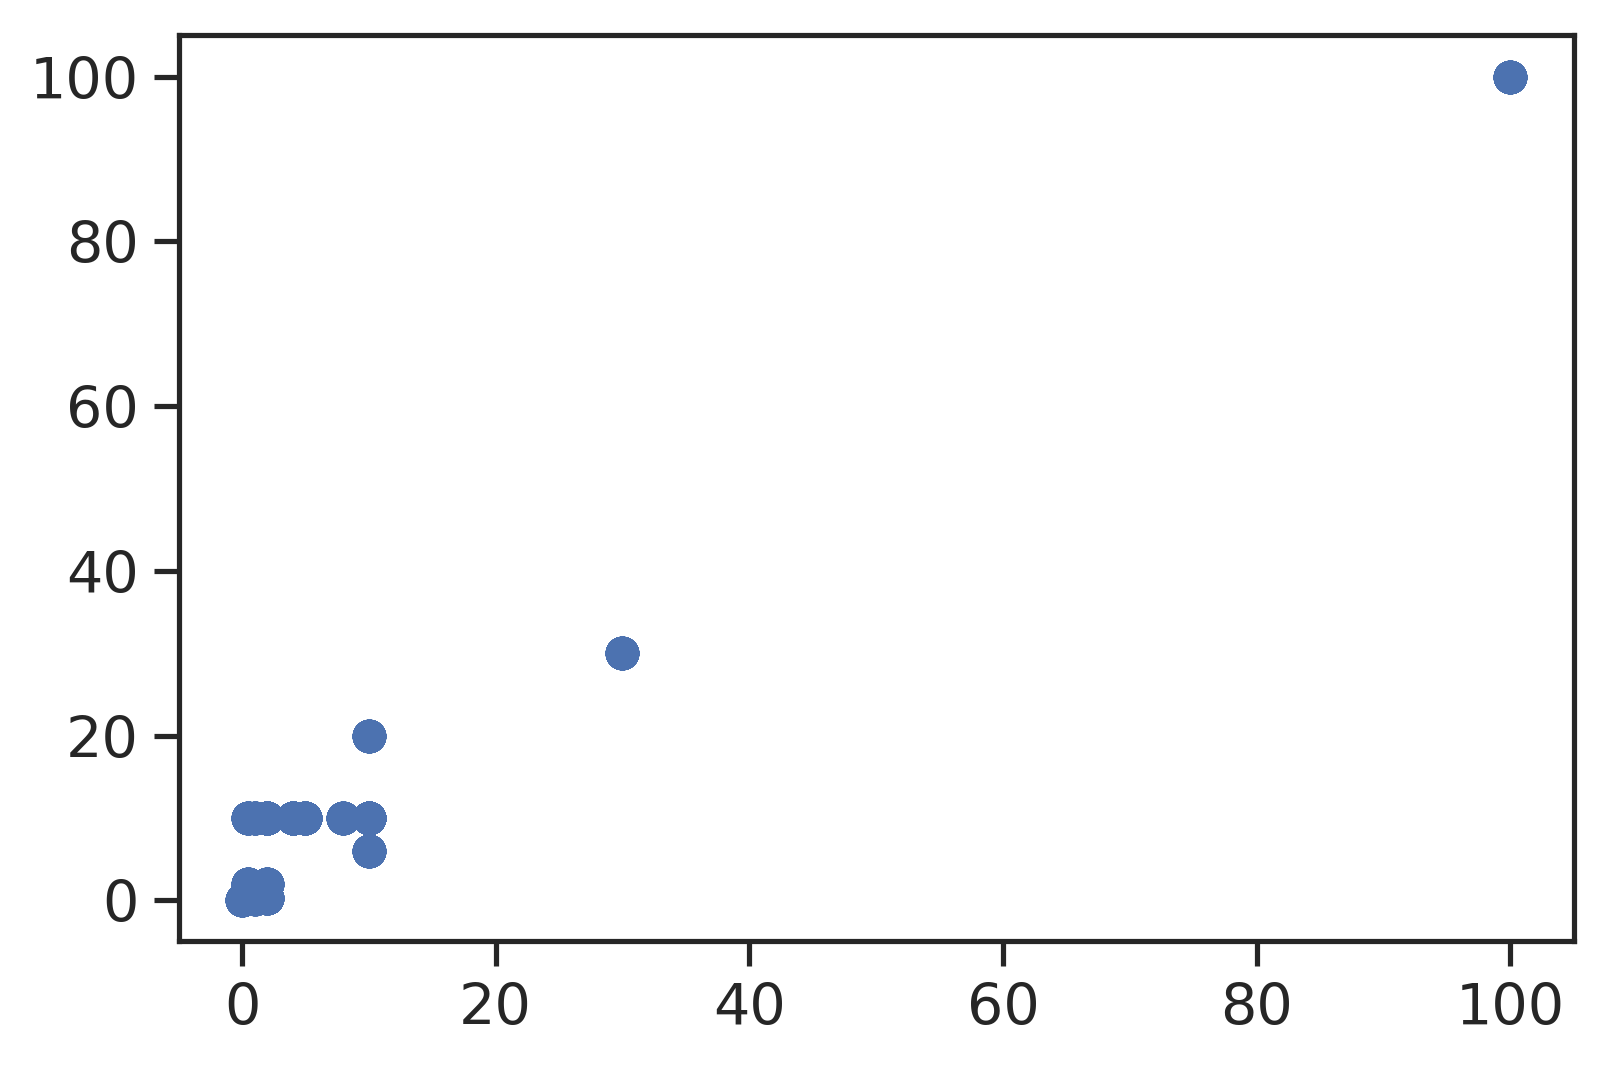

In [63]:
x1 = mc1_df.values.flatten()
x2 = mc2_df.values.flatten()
sel = np.logical_and(~np.isnan(x1), ~np.isnan(x2))

plt.scatter(x1[sel], x2[sel], s=50, alpha=0.75)